# MA3832 Assignment 4 - Capstone (Transfer Learning Model - VGG19)
Done By: Josiah Teh

## AWS Setup

In [1]:
%%sh
ls -l

total 881480
-rw-rw-r-- 1 ec2-user ec2-user 816029038 Jan 31 18:33 covid19-radiography-database.zip
drwxrwxr-x 6 ec2-user ec2-user      4096 Jan 31 18:33 COVID-19_Radiography_Dataset
drwx------ 2 ec2-user ec2-user     16384 Jan 31 18:25 lost+found
-rw-rw-r-- 1 ec2-user ec2-user     38899 Jan 31 19:46 MA3832_A4(Part2)_AWS.ipynb
-rw-rw-r-- 1 ec2-user ec2-user  86538136 Jan 31 20:05 VGG19_TL.h5


In [2]:
%%sh
sudo chown ec2-user lost+found
sudo chgrp ec2-user lost+found

In [3]:
%%sh
ls -l

total 881480
-rw-rw-r-- 1 ec2-user ec2-user 816029038 Jan 31 18:33 covid19-radiography-database.zip
drwxrwxr-x 6 ec2-user ec2-user      4096 Jan 31 18:33 COVID-19_Radiography_Dataset
drwx------ 2 ec2-user ec2-user     16384 Jan 31 18:25 lost+found
-rw-rw-r-- 1 ec2-user ec2-user     38899 Jan 31 19:46 MA3832_A4(Part2)_AWS.ipynb
-rw-rw-r-- 1 ec2-user ec2-user  86538136 Jan 31 20:05 VGG19_TL.h5


In [4]:
# Setup environment
import sagemaker #import sagemaker
print(sagemaker.__version__) 
sess = sagemaker.Session()                  
role = sagemaker.get_execution_role() 

2.127.0


While original plans were to take the test and train set from the S3 bucket, it came to my attention that my request limits related to elastic storage have reached their limit, therefore, I will be training the model on this instance

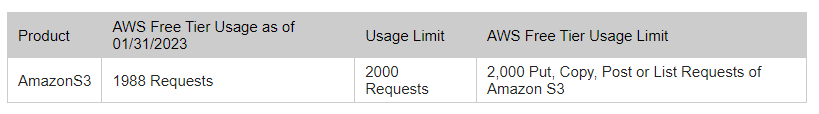

## Data Loading

In [5]:
# Kaggle login
import os
os.environ["KAGGLE_USERNAME"] = "wdaable"
os.environ["KAGGLE_KEY"] = "8c751c49490a2cd7beb3c9f912893fb6"

In [6]:
# ! pip install kaggle

In [7]:
# ! kaggle datasets download tawsifurrahman/covid19-radiography-database

In [8]:
# ! unzip covid19-radiography-database.zip

## Pre-processing

In [6]:
# Necessary libraries
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns 

Matplotlib is building the font cache; this may take a moment.
2023-01-31 20:07:21.188697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 20:07:44.181813: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# Create function to return images and labels
def load_images(path, label):
    images = []
    labels = []
    urls = os.listdir(path)
    for i in range(len(urls)):
        img_path = f"{path}/{urls[i]}"
        img = cv2.imread(img_path)
        # Resize the images
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(label)
    images = np.asarray(images)
    return images, labels

In [15]:
path = "COVID-19_Radiography_Dataset/Normal/images"
normal_images, normal_labels = load_images(path, 0)

# Check length of images to os directory
print(len(os.listdir(path)))
print(len(normal_images))
print(normal_images.shape)

10192
10192
(10192, 224, 224, 3)


In [16]:
path = "COVID-19_Radiography_Dataset/COVID/images"
COVID_images, COVID_labels = load_images(path, 1)

# Check length of images to os directory
print(len(os.listdir(path)))
print(len(COVID_images))
print(COVID_images.shape)

3616
3616
(3616, 224, 224, 3)


In [10]:
path = "COVID-19_Radiography_Dataset/Viral Pneumonia/images"
pneu_images, pneu_labels = load_images(path, 2)

# Check length of images to os directory
print(len(os.listdir(path)))
print(len(pneu_images))
print(pneu_images.shape)

1345
1345
(1345, 224, 224, 3)


In [11]:
# Join all images and labels together
x = np.r_[normal_images, COVID_images, pneu_images]
y = np.r_[normal_labels, COVID_labels, pneu_labels]

# Check
print(x.shape)
print(y.shape)

(15153, 224, 224, 3)
(15153,)


In [12]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Check
print(f"Shape of X Train: {x_train.shape}")
print(f"Shape of Y Train: {y_train.shape}")
print(f"Shape of X Test: {x_test.shape}")
print(f"Shape of Y Test: {y_test.shape}")

Shape of X Train: (12122, 224, 224, 3)
Shape of Y Train: (12122,)
Shape of X Test: (3031, 224, 224, 3)
Shape of Y Test: (3031,)


In [13]:
# Convert y variables to categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

## Initialise the transfer learning model

In [24]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

keras.backend.clear_session()

# Create base model from VGG19
base_model = VGG19(include_top= False, weights = 'imagenet') 
for layer in base_model.layers:
        layer.trainable = False

# Adjust base model to fit current needs
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- 3 classes
predictions = Dense(3, activation='softmax')(x)

# Create transfer learning model
tl_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
tl_model.compile(optimizer = "adam", loss = tf.keras.losses.CategoricalCrossentropy())
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, None, None)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, None, None)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, None, None)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, None, None)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, None, None)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, None, None)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, None, None)   0     

As the VGG19 model cannot be loaded properly, we will be using the model trained on our local machine. This model was trained 10 times, each iteration averaging 30 minutes, with the main VGG layers being frozen.

In [25]:
tl_model = keras.models.load_model("VGG19_TL.h5", compile=False)
tl_model.compile(optimizer = "adam", loss = tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy", keras.metrics.Precision()])
tl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

## Evaluation

In [26]:
tl_model.evaluate(x_test, y_test)

95/95 [==============================] - 552s 6s/step - loss: 0.1030 - accuracy: 0.9693 - precision: 0.9693


[0.10299206525087357, 0.9693170785903931, 0.9693170785903931]

In [27]:
# Prepare to plot predictions
predicted_vals = tl_model.predict(x_test)
predicted_y = np.argmax(predicted_vals, axis = 1)
predicted_y

95/95 [==============================] - 544s 6s/step


array([0, 2, 0, ..., 0, 0, 0])

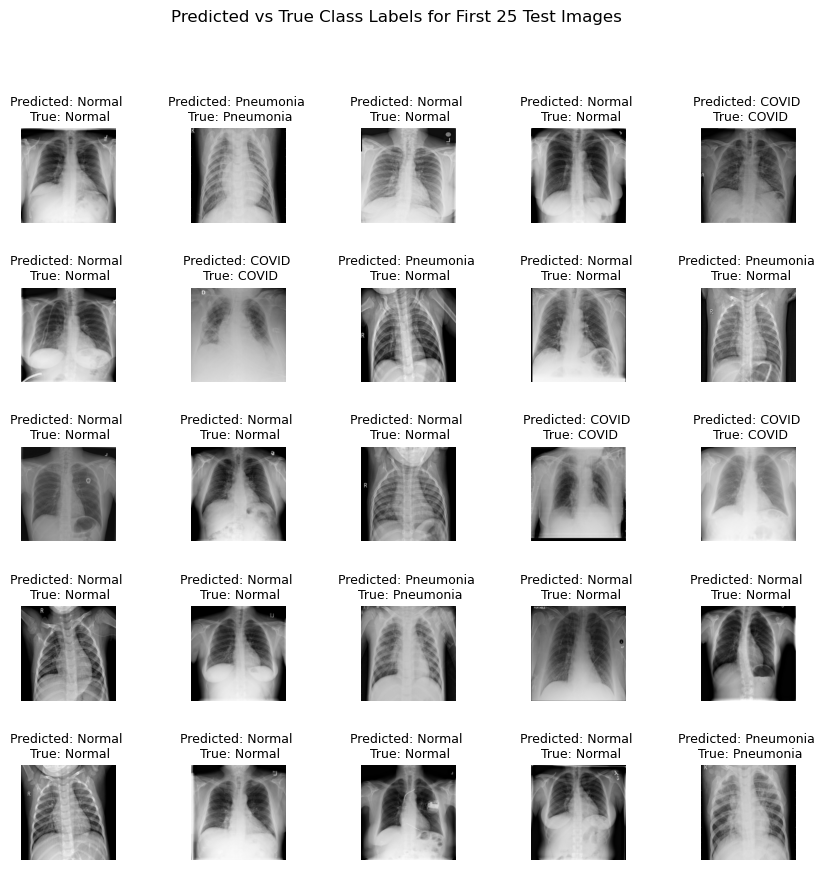

In [29]:
# Plot first 25 images
# Define class names
class_names = ["Normal", "COVID", "Pneumonia"]
true_y = np.argmax(y_test, axis = 1)
# Plot results
L = 5
W = 5

fig, axes = plt.subplots(L,W, figsize=(10, 10))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Predicted: {class_names[predicted_y[i]]} \n True: {class_names[true_y[i]]}", fontsize = 9)
    axes[i].axis('off')
    
plt.suptitle("Predicted vs True Class Labels for First 25 Test Images")
plt.subplots_adjust(wspace=0.8)

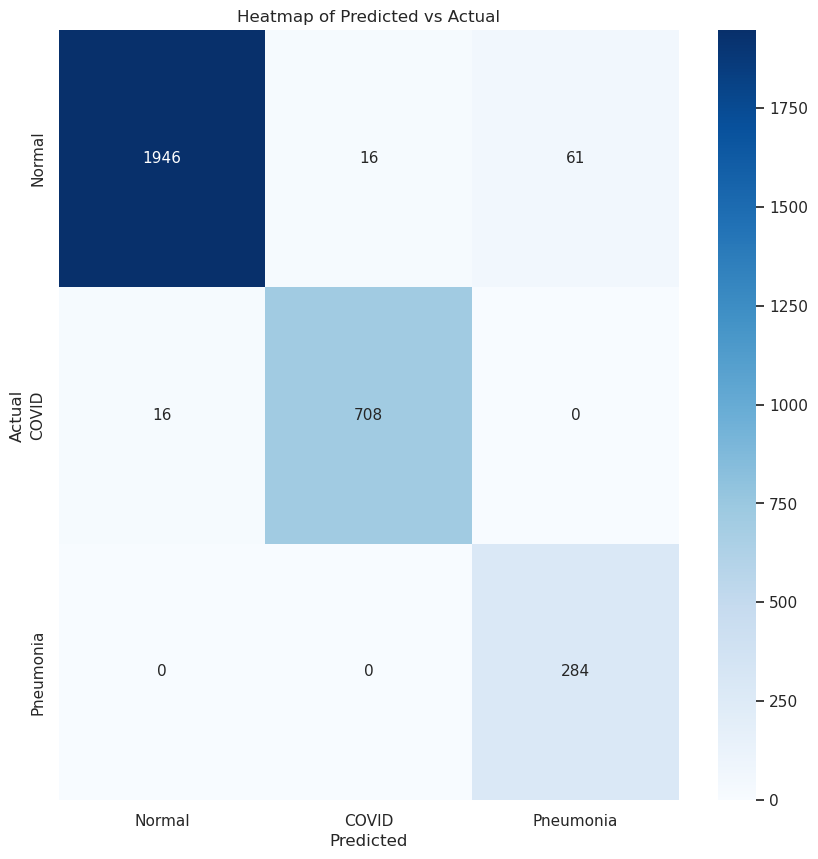

In [30]:
# Plot confusion matrix
cm = confusion_matrix(true_y, predicted_y)
df_cm = pd.DataFrame(cm, columns = class_names, index = class_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

sns.set(font_scale=0.9) # for label size
sns.set(rc={'figure.figsize':(10, 10)})
sns.heatmap(df_cm, cmap = "Blues", annot=True, annot_kws={"size": 11}, fmt='g').set(title = "Heatmap of Predicted vs Actual")# font size
plt.show()

In [31]:
# Classification report
print("Classification Report on Test Set")
print(classification_report(true_y, predicted_y, target_names = class_names))

Classification Report on Test Set
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98      2023
       COVID       0.98      0.98      0.98       724
   Pneumonia       0.82      1.00      0.90       284

    accuracy                           0.97      3031
   macro avg       0.93      0.98      0.95      3031
weighted avg       0.97      0.97      0.97      3031

